# VGG Transfer Learning for Solar Flare Prediction

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image as pil_image
import imageio
import tensorflow
import sklearn.metrics
import itertools
%matplotlib inline
#plt.rcParams.update({'font.size': 32})
%config Completer.use_jedi = False

In [2]:
def print_params(model):
    total_params = 0 # initialize counter for total params
    trainable_params = 0 # initialize counter for trainable params
    print('Layer Name\t\tType\t\tFilter shape\t\t# Parameters\tTrainable') # print column headings
    for layer in model.layers: # loop over layers
        lname = layer.name # grab layer name
        ltype = type(layer).__name__ # grab layer type
        ltype[ltype.find('/'):] # parse for only the last part of the string
        if ltype=='Conv2D': # print for convolutional layers
            weights = layer.get_weights()
            print(lname+'\t\t'+ltype+'\t\t'+str(weights[0].shape)+'\t\t'+\
                  str(layer.count_params())+'\t'+str(layer.trainable))
            if layer.trainable:
                trainable_params += layer.count_params()
            total_params += layer.count_params() # update number of params
        elif ltype=='MaxPooling2D': # print for max pool layers
            weights = layer.get_weights()
            print(lname+'\t\t'+ltype+'\t---------------\t\t---')
        elif ltype=='Flatten': # print for flatten layers
            print(lname+'\t\t'+ltype+'\t\t---------------\t\t---')
        elif ltype=='Dense': # print for dense layers
            weights = layer.get_weights()
            print(lname+'\t\t\t'+ltype+'\t\t'+str(weights[0].shape)+'\t\t'+\
                  str(layer.count_params())+'\t'+str(layer.trainable))
            if layer.trainable:
                trainable_params += layer.count_params()
            total_params += layer.count_params() # update number of params
        elif ltype=='Dropout': # print for dropout layers
            print(lname+'\t\t'+ltype+'\t\t------------------\t---')
    print('---------------')
    print('Total trainable parameters: '+str(trainable_params)) # print total params
    print('Total untrainable parameters: '+str(total_params-trainable_params))
    print('Total parameters: '+str(total_params))

In [3]:
def print_shapes(model):
    print('Layer Name\t\tType\t\tInput Shape\t\tOutput Shape\tTrainable')# print column headings
    for layer in model.layers:  # loop over layers
        lname = layer.name # grab layer name
        ltype = type(layer).__name__ # grab layer type
        ltype[ltype.find('/'):] # parse for only the last part of the string
        if ltype=='Conv2D': # print for convolutional layers
            print(lname+'\t\t'+ltype+'\t\t'+str(layer.input_shape)+'\t'+\
                  str(layer.output_shape)+'\t'+str(layer.trainable))
        elif ltype=='MaxPooling2D': # print for maxpool layers
            print(lname+'\t\t'+ltype+'\t'+str(layer.input_shape)+'\t'+\
                  str(layer.output_shape))
        elif ltype=='Flatten': # print for flatten layers
            print(lname+'\t\t'+ltype+'\t\t'+str(layer.input_shape)+'\t'+\
                  str(layer.output_shape))
        elif ltype=='Dense': # print for dense layers
            print(lname+'\t\t\t'+ltype+'\t\t'+str(layer.input_shape)+'\t\t'+\
                  str(layer.output_shape)+'\t'+str(layer.trainable))
        elif ltype=='Dropout': # print for dropout layers
            print(lname+'\t\t'+ltype+'\t\t'+str(layer.input_shape)+'\t'+\
                  str(layer.output_shape))

In [4]:
from keras.applications.vgg16 import preprocess_input
from astropy.io import fits
import skimage.transform

In [5]:
import keras
from keras.layers import Input
import keras.applications
input_tensor = Input(shape=(224,224,3))
model1 = keras.applications.vgg16.VGG16(include_top=False,weights='imagenet',input_tensor=input_tensor)

In [6]:
from keras.models import Model
from keras.layers import Dense, Flatten, Dropout
new_output = model1.output # take the output as currently defined
new_output = Flatten()(new_output)
#new_output = Dropout(0.5)(new_output) #was commented out
new_output = Dense(256,activation='relu')(new_output)
#new_output = Dropout(0.5)(new_output)
new_output = Dense(256,activation='relu')(new_output)
new_output = Dropout(0.5)(new_output) #default is 0.5
new_output = Dense(5,activation='softmax')(new_output) # this is for classification
# new_output = Dense(1,activation='linear')(new_output) #this is for regression
model2= Model(inputs=model1.input,outputs=new_output) # define a new model with the new output

In [7]:
print_params(model2)
#print(model2.summary())

Layer Name		Type		Filter shape		# Parameters	Trainable
block1_conv1		Conv2D		(3, 3, 3, 64)		1792	True
block1_conv2		Conv2D		(3, 3, 64, 64)		36928	True
block1_pool		MaxPooling2D	---------------		---
block2_conv1		Conv2D		(3, 3, 64, 128)		73856	True
block2_conv2		Conv2D		(3, 3, 128, 128)		147584	True
block2_pool		MaxPooling2D	---------------		---
block3_conv1		Conv2D		(3, 3, 128, 256)		295168	True
block3_conv2		Conv2D		(3, 3, 256, 256)		590080	True
block3_conv3		Conv2D		(3, 3, 256, 256)		590080	True
block3_pool		MaxPooling2D	---------------		---
block4_conv1		Conv2D		(3, 3, 256, 512)		1180160	True
block4_conv2		Conv2D		(3, 3, 512, 512)		2359808	True
block4_conv3		Conv2D		(3, 3, 512, 512)		2359808	True
block4_pool		MaxPooling2D	---------------		---
block5_conv1		Conv2D		(3, 3, 512, 512)		2359808	True
block5_conv2		Conv2D		(3, 3, 512, 512)		2359808	True
block5_conv3		Conv2D		(3, 3, 512, 512)		2359808	True
block5_pool		MaxPooling2D	---------------		---
flatten		Flatten		---------------		---

In [8]:
for layer in model2.layers[:-6]:
    layer.trainable=False

In [9]:
print_params(model2)

Layer Name		Type		Filter shape		# Parameters	Trainable
block1_conv1		Conv2D		(3, 3, 3, 64)		1792	False
block1_conv2		Conv2D		(3, 3, 64, 64)		36928	False
block1_pool		MaxPooling2D	---------------		---
block2_conv1		Conv2D		(3, 3, 64, 128)		73856	False
block2_conv2		Conv2D		(3, 3, 128, 128)		147584	False
block2_pool		MaxPooling2D	---------------		---
block3_conv1		Conv2D		(3, 3, 128, 256)		295168	False
block3_conv2		Conv2D		(3, 3, 256, 256)		590080	False
block3_conv3		Conv2D		(3, 3, 256, 256)		590080	False
block3_pool		MaxPooling2D	---------------		---
block4_conv1		Conv2D		(3, 3, 256, 512)		1180160	False
block4_conv2		Conv2D		(3, 3, 512, 512)		2359808	False
block4_conv3		Conv2D		(3, 3, 512, 512)		2359808	False
block4_pool		MaxPooling2D	---------------		---
block5_conv1		Conv2D		(3, 3, 512, 512)		2359808	False
block5_conv2		Conv2D		(3, 3, 512, 512)		2359808	False
block5_conv3		Conv2D		(3, 3, 512, 512)		2359808	False
block5_pool		MaxPooling2D	---------------		---
flatten		Flatten		-------

## Custom Data Generator

Approach taken from https://medium.com/analytics-vidhya/write-your-own-custom-data-generator-for-tensorflow-keras-1252b64e41c3

From https://www.tensorflow.org/api_docs/python/tf/keras/utils/Sequence: "Sequence are a safer way to do multiprocessing. This structure guarantees that the network will only train once on each sample per epoch which is not the case with generators."

In [10]:
from tensorflow.keras.utils import Sequence
from astropy.io import fits
from keras.applications.vgg16 import preprocess_input
import skimage.transform
class FitsDataGen(Sequence):
    # The input to the data generator will be the dataframe and which columns to use
    def __init__(self, df, X_col, y_col,
                 directory,
                 batch_size,
                 input_size=(224, 224, 3),
                 target_size=None,
                 bitdepth=None,
                 shuffle=True):
        
        self.df = df.copy() # dataframe
        self.X_col = X_col # column for X data (filename)
        self.y_col = y_col # column for y data (class label)
        self.directory = directory # base directory for data
        self.batch_size = batch_size # batch size
        self.input_size = input_size # size expected by network (224,224,3) for VGG
        self.target_size = target_size # resized image for spatial res sims
        self.bitdepth = bitdepth # quantized image for bitdepth sims
        self.shuffle = shuffle # whether to shuffle batches
        
        self.n = len(self.df) # number of data points
        self.nclasses = df[y_col].nunique() # number of classes
            
    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)
    
    def __get_input(self, path, directory, input_size, target_size, bitdepth):
    
        with fits.open(directory+path) as img: # read in fits image
            img.verify('silentfix')
            img = img[0].data
            
        #img = np.expand_dims(img,axis=2) # copy single channel to three to create rgb dimensioned image
        #img = np.tile(img,(1,1,3))
        
        # scale to target_size
        if target_size is not None:
            img = skimage.transform.resize(img, (target_size[0],target_size[1]), order=1, mode='reflect',\
                                           clip=True, preserve_range=True, anti_aliasing=True)
        
        # scale to input_size (expected dimensions for input to network)
        img = skimage.transform.resize(img, (input_size[0],input_size[1]), order=1, mode='reflect',\
                                       clip=True, preserve_range=True, anti_aliasing=True)
        
        # put bitdepth stuff here eventually
        
        # scale intensities to range [0,255] as expected by VGG preprocessing function
        # can cheat a bit here and treat each channel the same since these are grayscale images
        # img = img + 5978.7 # -5978.7 is minimum of entire magnetogram dataset
        # img = img/(2*5978.7)*255 # +5978.7 is maximum of entire magnetogram dataset
        # img[img<-2550] = -2550
        # img = img + 2550 # -5978.7 is minimum of entire magnetogram dataset
        # img = img/(5100)*255 # +5978.7 is maximum of entire magnetogram dataset
        img = img/(3500)*255 #changed to 3500 because some pixels need clipping
        img[img>255] = 255
        
        
        
        img = preprocess_input(img) # preprocess according to VGG expectations

        return img
    
    
    def __get_output(self, label, num_classes):
        #print(label)
        print(label, num_classes)
        return tensorflow.keras.utils.to_categorical(label, num_classes=num_classes)
    
    def __get_data(self, batches):
        # Generates data containing batch_size samples

        path_batch = batches[self.X_col]
        
        label_batch = batches[self.y_col]

        X_batch = np.asarray([self.__get_input(x, self.directory, self.input_size, self.target_size, self.bitdepth)\
                              for x in path_batch])

        y_batch = np.asarray([self.__get_output(y, self.nclasses) for y in label_batch])
        print(y_batch)
        
        return X_batch, y_batch
    
    def __getitem__(self, index):
        
        batches = self.df[index * self.batch_size:(index + 1) * self.batch_size]
        X, y = self.__get_data(batches)        
        return X, y
    
    def __len__(self):
        return self.n // self.batch_size

In [11]:
# train_df = pd.read_csv('train_data.csv',dtype=str)
# val_df = pd.read_csv('val_data.csv',dtype=str)
# test_df = pd.read_csv('test_data.csv',dtype=str)

In [12]:
# train_df = train_df.sample(frac=1).reset_index(drop=True)
# val_df = val_df.sample(frac=1).reset_index(drop=True)
# test_df = test_df.sample(frac=1).reset_index(drop=True)

In [13]:
# train_generator = FitsDataGen(train_df, X_col='filename', y_col='class', directory='',\
#                               batch_size=128, input_size=(224,224,3),\
#                            target_size=None, bitdepth=None, shuffle=True)
# val_generator = FitsDataGen(val_df, X_col='filename', y_col='class', directory='',\
#                             batch_size=128, input_size=(224,224,3),\
#                            target_size=None, bitdepth=None, shuffle=True)

## Dataframe approach

In [14]:
# train_df = pd.read_csv('classifier_VGG/Train_Data_by_AR_sr600x600.csv',dtype=str)
# val_df = pd.read_csv('classifier_VGG/Validation_data_by_AR_sr600x600.csv',dtype=str)
# test_df = pd.read_csv('classifier_VGG/Test_Data_by_AR_sr600x600.csv',dtype=str)

train_df = pd.read_csv('train_data_DHE_ALL.csv',dtype=str)
val_df = pd.read_csv('val_data_DHE_ALL.csv',dtype=str)
test_df = pd.read_csv('test_data_DHE_ALL.csv',dtype=str)

In [15]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import decode_predictions

train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
train_generator = train_datagen.flow_from_dataframe(dataframe=train_df,\
                                                    directory='',\
                                                    xcol='filename',y_col='class',\
                                                    target_size=(224,224), color_mode='rgb',\
                                                    batch_size=128, class_mode='categorical',\
                                                    shuffle=True) #RETURN TO TRUEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
val_generator = val_datagen.flow_from_dataframe(dataframe=val_df,\
                                                directory = '',\
                                                xcol='filename',ycol='class',\
                                                target_size=(224,224), color_mode='rgb',\
                                                batch_size=128, class_mode='categorical',\
                                                shuffle=True)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_generator = test_datagen.flow_from_dataframe(dataframe=test_df,\
                                                directory = '',\
                                                xcol='filename',ycol='class',\
                                                target_size=(224,224), color_mode='rgb',\
                                                batch_size=128, class_mode='categorical',\
                                                shuffle=False) #SHOULD STAY FALSEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE

Found 3741 validated image filenames belonging to 5 classes.
Found 1068 validated image filenames belonging to 5 classes.
Found 533 validated image filenames belonging to 5 classes.


## Dataset approach

In [16]:
# from keras.preprocessing.image import ImageDataGenerator
# from keras.applications.vgg16 import preprocess_input
# from keras.applications.vgg16 import decode_predictions
# train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
# train_generator = train_datagen.flow_from_directory('BCS_sorted_HDV\\',\
#                                                     target_size=(224,224), color_mode='rgb',\
#                                                     batch_size=128, class_mode='categorical',\
#                                                     shuffle=True)
# val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
# val_generator = val_datagen.flow_from_directory('BCS_sorted_HDV\\',\
#                                                     target_size=(224,224), color_mode='rgb',\
#                                                     batch_size=128, class_mode='categorical',\
#                                                     shuffle=True)

In [17]:
def categorical_tnr(y_true,y_pred):
    import keras.backend as K
    y_true = K.argmax(y_true)
    y_pred = K.argmax(y_pred)
    neg_y_true = 1 - y_true
    neg_y_pred = 1 - y_pred
    fp = K.cast(K.sum(neg_y_true * y_pred),'float32')
    tn = K.cast(K.sum(neg_y_true * neg_y_pred),'float32')
    tnr = tn / (tn + fp + K.epsilon())
    return tnr

def categorical_tpr(y_true,y_pred):
    import keras.backend as K
    y_true = K.argmax(y_true)
    y_pred = K.argmax(y_pred)
    neg_y_pred = 1 - y_pred
    fn = K.cast(K.sum(y_true * neg_y_pred),'float32')
    tp = K.cast(K.sum(y_true * y_pred),'float32')
    tpr = tp / (tp + fn + K.epsilon())
    return tpr

def categorical_tss(y_true,y_pred):
    import keras.backend as K
    tpr = categorical_tpr(y_true,y_pred)
    tnr = categorical_tnr(y_true,y_pred)
    tss = tpr + tnr - 1
    return tss

def save_con_mat(y_true, y_pred):
    import tensorflow as tf
    print((y_true.shape))
    print((y_pred.shape))
    con_matrix = tf.math.confusion_matrix(y_true, y_pred)
    # acc=np.diag(con_matrix).sum().astype(float)/con_matrix.sum()
    return con_matrix


In [18]:
from tensorflow.keras.optimizers import Adam
adam_opt = Adam(learning_rate=0.001)
model2.compile(loss='categorical_crossentropy', optimizer=adam_opt,\
               metrics=['categorical_accuracy'])# save_con_mat]) #,categorical_tnr,categorical_tpr,categorical_tss])
#for classification

# model2.compile(loss='mean_absolute_percentage_error', optimizer=adam_opt,\
#                metrics=['categorical_accuracy'])# save_con_mat]) #,categorical_tnr,categorical_tpr,categorical_tss])
#                # for regressions

In [19]:
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping

filepath = 'BCS_CNN\\BCS_CNN.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='val_categorical_tss', verbose=1, save_best_only=False, mode='max')
early_stop = EarlyStopping(monitor='val_categorical_tss', min_delta=0.001, patience=5, verbose=1, mode='max')
#callbacks_list = [checkpoint, early_stop]
callbacks_list = [checkpoint]

step_size_train = np.ceil(train_generator.n/train_generator.batch_size)
print(step_size_train)
print('Batch size: ', train_generator.batch_size)
#step_size_train = 2373 # to help debug val accuracy issue
step_size_val = np.ceil(val_generator.n/val_generator.batch_size)
print(step_size_val)
#step_size_val = 303 # to help debug val accuracy issue

# the following assumes that 0 is the majority class
# class_weights = {0: 1.,
#                  1: (np.asarray(train_generator.classes)==0).sum()/(np.asarray(train_generator.classes)==1).sum()}
# the following taken from https://www.tensorflow.org/tutorials/structured_data/imbalanced_data
#class_weights = {0: (1/(train_generator.classes==0).sum())*len(train_generator.classes)/2,
#                 1: (1/(train_generator.classes==1).sum())*len(train_generator.classes)/2}
# class_weights = {0: 1.,
#                 1: 6.}

from sklearn.utils import class_weight 
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(train_df['class']), y =train_df['class'])
class_weights = dict(enumerate(class_weights))

30.0
Batch size:  128
9.0


In [20]:
print(class_weights)
# class_weights[0] = 2
# class_weights[1] = 1.5
# class_weights[2] = 0.2
# class_weights[3] = 1.3
# class_weights[4] = 7
# print(class_weights)


{0: 1.425142857142857, 1: 1.4388461538461539, 2: 0.4241496598639456, 3: 0.9091130012150668, 4: 6.864220183486238}


In [37]:
history = model2.fit(train_generator, steps_per_epoch=step_size_train, epochs=10, verbose=1,\
                     callbacks=callbacks_list, validation_data=val_generator, validation_steps=step_size_val,\
                     validation_freq=1, class_weight=class_weights)

Epoch 1/10
30/30 [==============================] - ETA: 0s - loss: 1.5289 - categorical_accuracy: 0.6792
Epoch 00001: saving model to BCS_CNN\BCS_CNN.hdf5
30/30 [==============================] - 13s 425ms/step - loss: 1.5289 - categorical_accuracy: 0.6792 - val_loss: 0.7094 - val_categorical_accuracy: 0.8577
Epoch 2/10
30/30 [==============================] - ETA: 0s - loss: 0.8235 - categorical_accuracy: 0.7934
Epoch 00002: saving model to BCS_CNN\BCS_CNN.hdf5
30/30 [==============================] - 12s 384ms/step - loss: 0.8235 - categorical_accuracy: 0.7934 - val_loss: 0.5815 - val_categorical_accuracy: 0.8221
Epoch 3/10


KeyboardInterrupt: 

In [39]:
for i, w in enumerate(model2.weights): print(i, w.name)
model2.save('BCS_CNN\\test.hdf5')

0 block1_conv1/kernel:0
1 block1_conv1/bias:0
2 block1_conv2/kernel:0
3 block1_conv2/bias:0
4 block2_conv1/kernel:0
5 block2_conv1/bias:0
6 block2_conv2/kernel:0
7 block2_conv2/bias:0
8 block3_conv1/kernel:0
9 block3_conv1/bias:0
10 block3_conv2/kernel:0
11 block3_conv2/bias:0
12 block3_conv3/kernel:0
13 block3_conv3/bias:0
14 block4_conv1/kernel:0
15 block4_conv1/bias:0
16 block4_conv2/kernel:0
17 block4_conv2/bias:0
18 block4_conv3/kernel:0
19 block4_conv3/bias:0
20 block5_conv1/kernel:0
21 block5_conv1/bias:0
22 block5_conv2/kernel:0
23 block5_conv2/bias:0
24 block5_conv3/kernel:0
25 block5_conv3/bias:0
26 dense/kernel:0
27 dense/bias:0
28 dense_1/kernel:0
29 dense_1/bias:0
30 dense_2/kernel:0
31 dense_2/bias:0


In [23]:
def normalize_Xtrain(X_train):
    mn = []
    mx = []
    Xn_train = np.zeros(np.shape(X_train))
    X_norm = np.zeros(np.shape(X_train))
    for i in range(len(X_train[0, ::])):
        mn.append(np.min(X_train[::, i]))
        Xn_train[::, i] = X_train[::, i] - mn[i]
    for i in range(len(X_train[0, ::])):
        mx.append(np.max(Xn_train[::, i]))
        if mx[i] == 0:
            X_norm[::, i] = 0
        if mx[i] != 0:
            X_norm[::, i] = Xn_train[::, i]/mx[i]
            
    return X_norm, mx, mn

[2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 5 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 2 2 2 2 2 2 2 2 2 3 2 2 2 2 2 2 2 2
 2 4 3 4 3 3 4 3 4 3 3 3 5 3 3 2 3 4 3 3 3 3 3 3 3 3 3 3 4 3 4 3 3 3 5 3 3
 3 3 3 3 3 3 3 3 3 4 3 3 3 5 3 3 6 4 3 4 2 3 4 4 6 3 3 3 4 3 3 3 4 3 4 3 3
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 3 2 4 4 4 4 4 4 6 4 4 4 3 4 2 4 3 4 4 4 4
 4 4 4 4 5 2 4 4 4 4 5 4 4 4 4]
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4

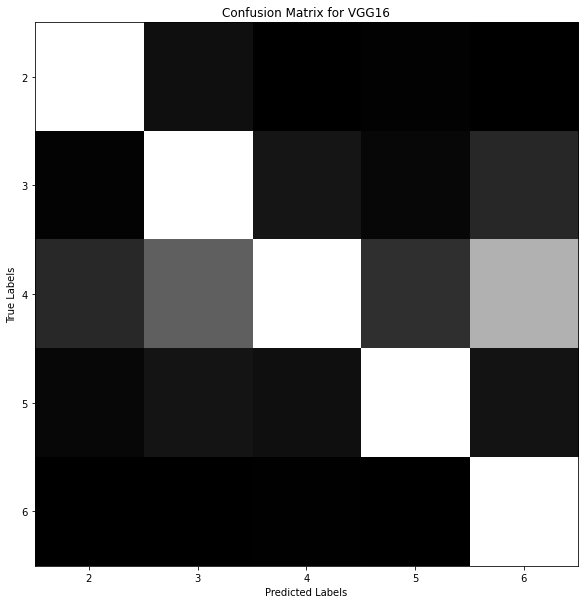

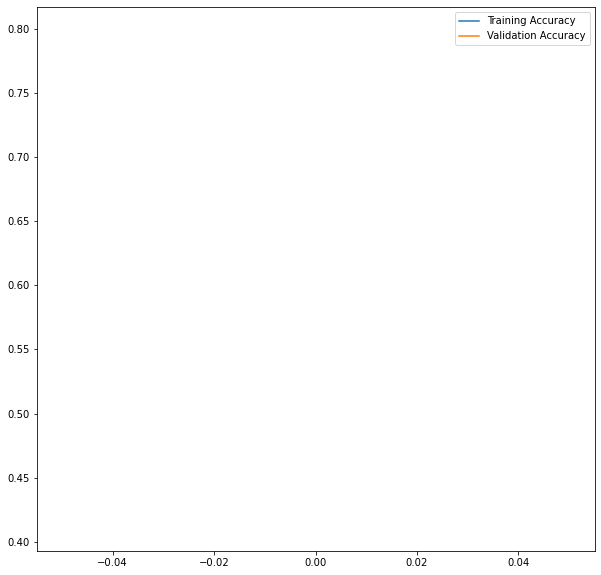

In [24]:
import sklearn.metrics

Y_test_hat=model2.predict(test_generator)
y_test_hat=Y_test_hat.argmax(axis=-1)+2

print(y_test_hat[:200])


y_test = test_df['class']
y_test = [int(i) for i in y_test]
print(y_test[:200])

con_matrix = sklearn.metrics.confusion_matrix(y_test,y_test_hat)
acc=np.diag(con_matrix).sum().astype(float)/con_matrix.sum()
# acc = tensorflow.keras.metrics.Accuracy()
# acc.reset_state()
# acc.update_state(y_test, y_test_hat)


print('The accuracy of SqueezeNet is: ', acc)

min = np.min(con_matrix)
max = np.max(con_matrix)
temp_mat = con_matrix - min
temp_mat = con_matrix/max

plt.figure(figsize=(10,10))
plt.imshow(normalize_Xtrain(con_matrix)[0], cmap='gray')
plt.title('Confusion Matrix for VGG16')
plt.xticks(list(range(len(['2', '3', '4', '5', '6']))), ['2', '3', '4', '5', '6'])
plt.yticks(list(range(len(['2', '3', '4', '5', '6']))), ['2', '3', '4', '5', '6'])
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')

print(history.history.keys())
plt.figure(figsize=(10,10))
plt.plot(np.arange(0, len(history.history['categorical_accuracy'])), history.history['categorical_accuracy'])
plt.plot(np.arange(0, len(history.history['val_categorical_accuracy'])), history.history['val_categorical_accuracy'])
plt.legend(('Training Accuracy', 'Validation Accuracy'))

#Metrics
precision = sklearn.metrics.precision_score(y_test,y_test_hat, average='macro')
print('Model precision is: ', precision)

f1_score = sklearn.metrics.f1_score(y_test,y_test_hat, average='macro')
print('Model f1_score is: ', f1_score)

recall = sklearn.metrics.recall_score(y_test,y_test_hat, average='macro')
print('Model recall is: ', recall)

MSE = sklearn.metrics.mean_squared_error(y_test,y_test_hat)
print('Model MSE is: ', MSE)

print("Confusion Matrix")
print(con_matrix)

[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 5, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 3, 3, 6, 3, 3, 3, 3, 3, 3, 3, 6, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 4, 4, 4, 4, 4, 4, 6, 4, 4, 4, 4, 4, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 6, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 6, 4, 4, 4, 2, 4, 4, 4, 4, 4, 4, 4, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 4, 4, 4, 4, 4, 4, 4, 4, 6, 4, 4, 4, 4, 4, 4, 4, 4, 2, 4, 4, 4, 4, 4, 

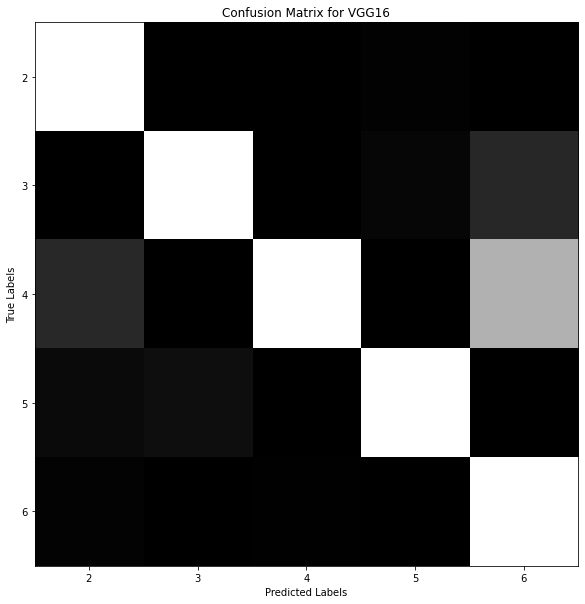

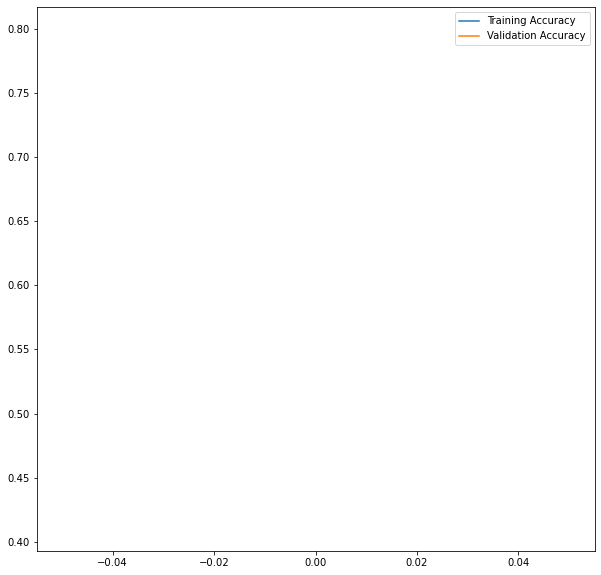

In [25]:
y_within_1 = []
for i in range(0, len(y_test)):
    if ((y_test_hat[i] == y_test[i]+1) or (y_test_hat[i] == y_test[i]-1) or (y_test_hat[i] == y_test[i])):
        y_within_1.append(y_test[i])
    else:
        y_within_1.append(y_test_hat[i])

print(y_within_1)
print(type(y_within_1[20]))
print(type(y_test[0]))

con_matrix = sklearn.metrics.confusion_matrix(y_test,y_within_1)
acc=np.diag(con_matrix).sum().astype(float)/con_matrix.sum()


print('The accuracy of the network model2 is: ', acc)

min = np.min(con_matrix)
max = np.max(con_matrix)
temp_mat = con_matrix - min
temp_mat = con_matrix/max

plt.figure(figsize=(10,10))
plt.imshow(normalize_Xtrain(con_matrix)[0], cmap='gray')
plt.title('Confusion Matrix for VGG16')
plt.xticks(list(range(len(['2', '3', '4', '5', '6']))), ['2', '3', '4', '5', '6'])
plt.yticks(list(range(len(['2', '3', '4', '5', '6']))), ['2', '3', '4', '5', '6'])
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')


print(history.history.keys())
plt.figure(figsize=(10,10))
plt.plot(np.arange(0, len(history.history['categorical_accuracy'])), history.history['categorical_accuracy'])
plt.plot(np.arange(0, len(history.history['val_categorical_accuracy'])), history.history['val_categorical_accuracy'])
plt.legend(('Training Accuracy', 'Validation Accuracy'))

#Metrics
precision = sklearn.metrics.precision_score(y_test,y_within_1, average='macro')
print('Model unweighted precision is: ', precision)
precision = sklearn.metrics.precision_score(y_test,y_within_1, average='weighted')
print('Model weighted precision is: ', precision)
print()

#print('Avg :', sklearn.metrics.accuracy_score(y_test, y_test_hat, normalize=False))

recall = sklearn.metrics.recall_score(y_test,y_within_1, average='macro')
print('Model unweighted recall is: ', recall)
recall = sklearn.metrics.recall_score(y_test,y_within_1, average='weighted')
print('Model weighted recall is: ', recall)
print()

f1_score = sklearn.metrics.f1_score(y_test,y_within_1, average='macro')
print('Model unweighted f1_score is: ', f1_score)
f1_score = sklearn.metrics.f1_score(y_test,y_within_1, average='weighted')
print('Model weighted f1_score is: ', f1_score)
print()


print("Confusion Matrix")
print(con_matrix)

In [26]:
# model2.fit(train_generator, steps_per_epoch=step_size_train, epochs=10, verbose=1,\
#                      callbacks=callbacks_list, validation_data=val_generator, validation_steps=step_size_val,\
#                      validation_freq=1, class_weight=class_weights, max_queue_size=100, workers=20, use_multiprocessing=True)

In [27]:
# model2.fit(ImageDataGenerator, steps_per_epoch=step_size_train, epochs=10, verbose=1,\
#                      callbacks=callbacks_list, validation_data=val_generator, validation_steps=step_size_val,\
#                      validation_freq=1, class_weight=class_weights,\
#                      max_queue_size=100, workers=16, use_multiprocessing=True)

In [28]:
# help(model2.fit)

In [29]:
# from keras.models import load_model
# model2 = load_model('model.best.hdf5', custom_objects={'categorical_tnr': categorical_tnr,\
#                                                        'categorical_tpr': categorical_tpr,\
#                                                        'categorical_tss': categorical_tss})
# model2.compile(loss='categorical_crossentropy', optimizer=adam_opt,\
#                metrics=['categorical_accuracy',categorical_tnr,categorical_tpr,categorical_tss])

In [30]:
# from keras.preprocessing.image import ImageDataGenerator
# from keras.applications.vgg16 import preprocess_input

# test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
# test_generator = test_datagen.flow_from_directory('VGG_AR_Dataset/TestSet_224',\
#                                                 target_size=(224,224), color_mode='rgb',\
#                                                 batch_size=128, class_mode='categorical',\
#                                                 shuffle=True)

In [31]:
#model2.evaluate(test_generator)

In [32]:
#help(model2.evaluate)

In [33]:
#(test_generator.labels==0).sum()

In [34]:
#(test_generator.labels==1).sum()